# Phân tích dữ liệu chứng khoán

In [8]:
# Khai báo thư viện
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
from statsmodels.tsa.stattools import acf, adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [9]:
# Đọc dữ liệu
stock = pd.read_excel(r'D:\chuoitg\train_files\time series forecast\stock1332.xlsx', 
                         parse_dates=['Date']).set_index('Date')

In [10]:
# Lọc dữ liệu cổ phiếu 1332
stock1332 = stock[stock.SecuritiesCode==1332][['Close']].dropna()
stock1332.head()

,Close
Date,
2017-01-04,571
2017-01-05,568
2017-01-06,575
2017-01-10,562
2017-01-11,553


In [11]:
# Xem thông tin bảng dữ liệu
stock1332.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 553 entries, 2017-01-04 to 2019-04-03
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Close   553 non-null    int64
dtypes: int64(1)
memory usage: 8.6 KB


<AxesSubplot: xlabel='Date'>

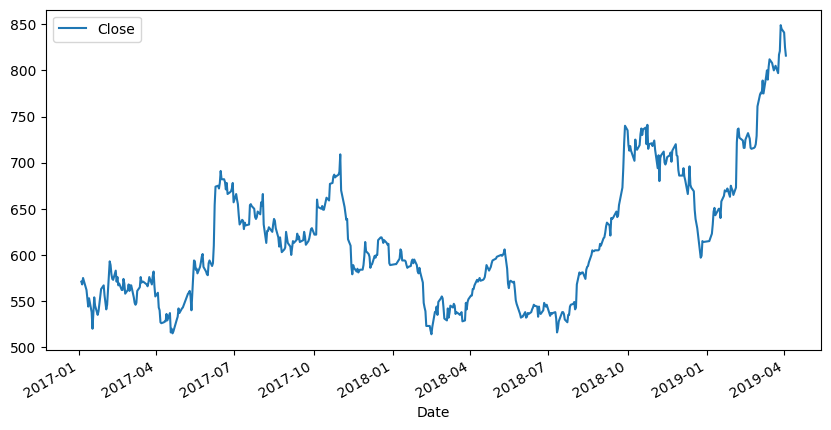

In [12]:
# Biểu diễn hình ảnh
stock1332.plot(figsize=(10,5))

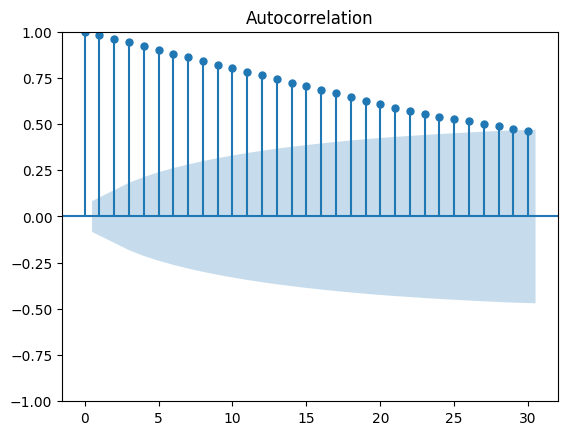

In [13]:
# Biểu đồ tự tương quan ACF
fig = plot_acf(stock1332, lags=30)

**Nhận xét**: biểu đồ acf giảm chậm, tuyến tính về 0 nên chuỗi thời gian là không dừng.

=> lấy sai phân

<AxesSubplot: xlabel='Date'>

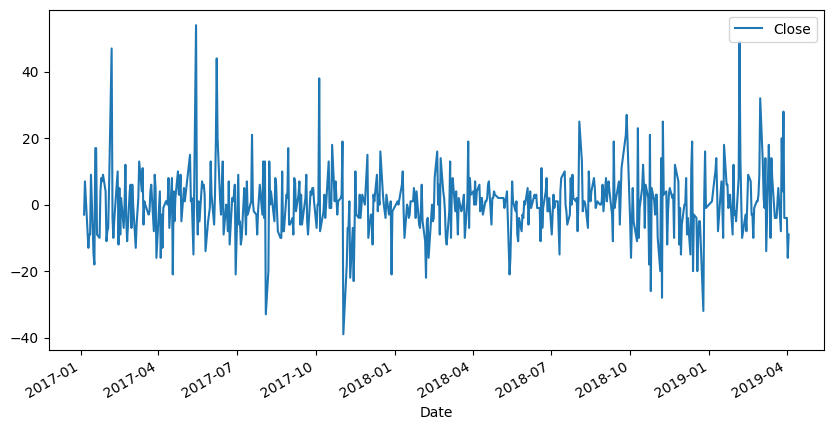

In [14]:
# Lấy sai phân
data = stock1332.diff().dropna()
data.plot(figsize=(10,5))

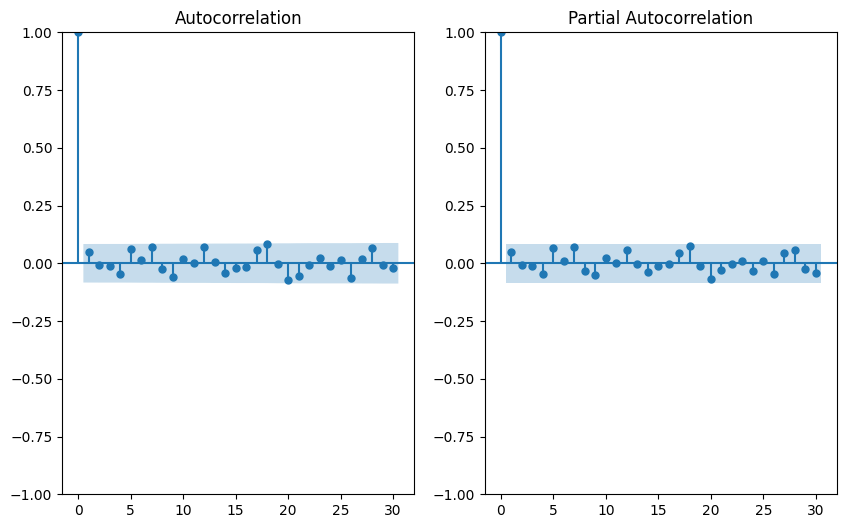

In [15]:
fig, ax = plt.subplots(1,2,figsize=(10,6))
fig = plot_acf(data, lags = 30, ax = ax[0])
fig = plot_pacf(data, lags = 30, method = 'ywm', ax = ax[1])

In [16]:
from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore")

In [17]:
stepwise_fit = auto_arima(stock1332,trace=True,suppress_warnings=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4118.387, Time=0.69 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4112.725, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4113.490, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4113.474, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4111.811, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4115.461, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.937 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  553
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2054.905
Date:                Fri, 27 Jan 2023   AIC                           4111.811
Time:                        13:16:47   BIC                           4116.124
Sample:                             0   HQIC                          4113.496
                                - 553                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       100.2295      3.352     29.902      0.000      93.660     106.799
===================================================================================
Ljung-Box (L1) (Q):                   1.24   Jarque-Bera (JB):               484.31
Prob(Q):                              0.27   Prob(JB):                         0.00
Heteroskedasticity (H):               1.07   Skew:                             0.69
Prob(H) (two-sided):                  0.63   Kurtosis:                         7.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**Nhận xét**: chuỗi sai phân là chuỗi dừng => sử dụng ARMA(p,q) để mô hình hoá chuỗi sai phân.

=> Chọn bậc: dựa vào 2 biểu đồ acf, pacf, ta chọn $p=0$; $q=0$

=> Quá trình ARIMA tương ứng có bậc (0,1,0)

In [18]:
# Ước lượng mô hình
model = ARIMA(stock1332.values, order=(1,2,0))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  553
Model:                 ARIMA(1, 2, 0)   Log Likelihood               -2158.790
Date:                Fri, 27 Jan 2023   AIC                           4321.579
Time:                        13:16:47   BIC                           4330.203
Sample:                             0   HQIC                          4324.949
                                - 553                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4727      0.027    -17.426      0.000      -0.526      -0.420
sigma2       148.0525      5.746     25.766      0.000     136.791     159.314
===================================================================================
Ljung-Box (L1) (Q):                  12.56   Jarque-Bera (JB):               194.14
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.94   Skew:                             0.32
Prob(H) (two-sided):                  0.68   Kurtosis:                         5.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [19]:
# Tham số ước lượng
result.params

array([ -0.47266419, 148.05253903])

**Kết quả**: Mô hình ARIMA có dạng
$$\nabla y_t = a_t $$

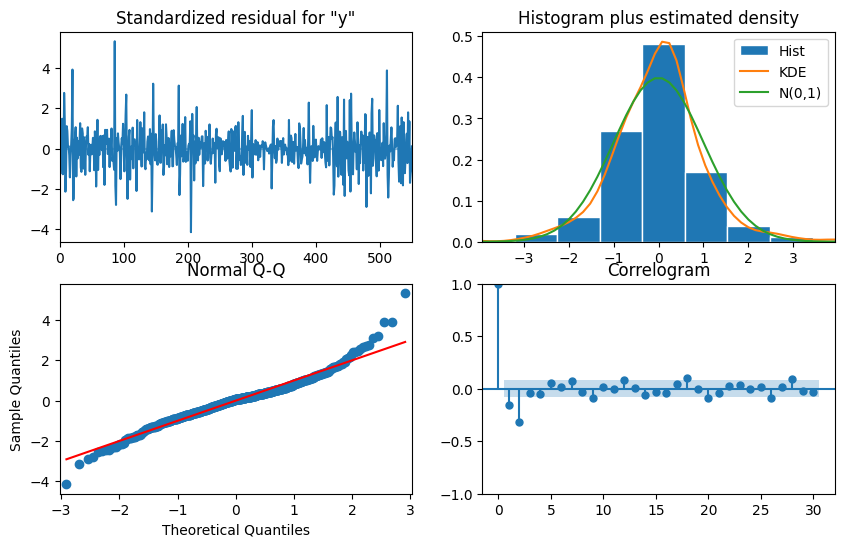

In [20]:
# Đánh giá mô hình bằng phần dư
fig = plt.figure(figsize=(10, 6))
fig = result.plot_diagnostics(fig=fig, lags=30)

**Kết luận**: phần dư là nhiễu trắng Gauss

In [21]:
# Đánh giá mô hình bằng Qstat
res = result.resid
r, q, p = acf(res, nlags=20, qstat=True)
pd.DataFrame(np.array([np.arange(1, 21), r[1:], q, p]).T,
             columns=["lag", "acf", "Qstat", "pvalue"]).set_index('lag')

,acf,Qstat,pvalue
lag,,,
1.0,-0.366300,74.602231,5.757811e-18
2.0,-0.032093,75.175921,4.739757e-17
3.0,-0.020596,75.412632,2.955736e-16
4.0,-0.016517,75.565152,1.513116e-15
5.0,-0.000085,75.565156,7.090241e-15
6.0,0.031939,76.137514,2.238013e-14
7.0,0.002007,76.139779,8.414415e-14
8.0,-0.042305,77.147658,1.830278e-13
9.0,0.015338,77.280383,5.595608e-13


**Nhận xét**: Ở độ trễ 20, Qstat = 4.740742 với p-value = 0.999817

=> Với mức ý nghĩa 5%, mô hình phù hợp với dữ liệu

### Dự báo 5 ngày giao dịch tiếp theo

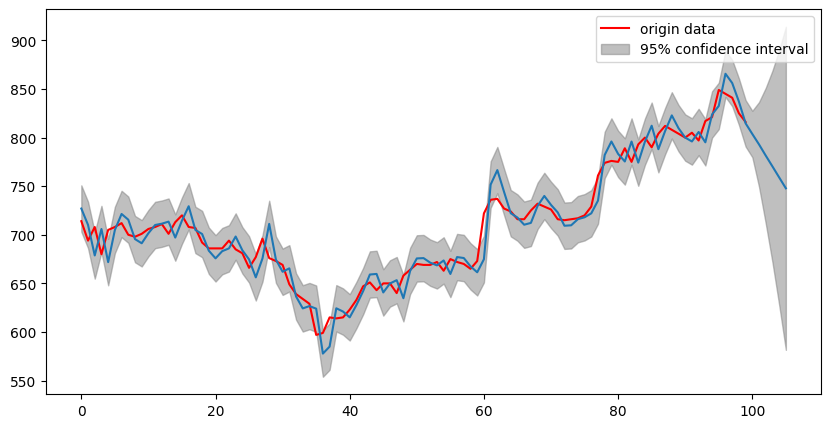

In [22]:
fig, ax = plt.subplots(figsize=(10,5))
plt.plot(stock1332.values[-100:],'-',color='red', label = 'origin data')
fig = plot_predict(result,
                   start = stock1332.shape[0]-100,
                   end = stock1332.shape[0]+5,
                   ax=ax)